### ASSOCIATION RULES - ALL APPROACHES

This notebook generates and evaluates association rules using 3 approaches:
1. By Department (intra-department rules)
2. Cross-Department (global rules across all departments)
3. By Segment (RFM segment-specific rules)

## I. Import and prepare data

### I.1. Import raw data

In [17]:
import pandas as pd
import sys
import os

sys.path.append('../scripts')  # To import from parent directory

from load_data import load_instacart_data
from split_data import temporal_split_instacart
from functions_association_rules import (
    prepare_transactions_from_csv,
    generate_association_rules,
    get_top_products_from_csv,
    evaluate_rules_from_csv,
    print_evaluation_results,
    csv_chunk_generator
)

In [2]:
data = load_instacart_data()

orders = data['orders']
order_products_prior = data['order_products_prior']
order_products_train = data['order_products_train']
products = data['products']
departments = data['departments']

### I.2. Generate train/testing set

In [3]:
# Check if split already exists
if os.path.exists('../data/processed/train.csv') and os.path.exists('../data/processed/test.csv'):
    print("  Split files already exist")
else:
    print("  Creating new split...")
    temporal_split_instacart(
        order_products_prior=order_products_prior,
        order_products_train=order_products_train,
        orders=orders,
        products=products,
        departments=departments,
        train_ratio=0.7,  # 70% train, 30% test
        save_path='../data/processed/'
    )

  Creating new split...

[1/6] Merging prior + train datasets...
  Total rows: 33,819,106
  Unique orders: 3,346,083
  Unique products: 49,685

[2/6] Temporal split based on order_number...
  Total orders: 3,421,083
  Train orders: 2,394,758 (70.0%)
  Test orders: 1,026,325 (30.0%)

  Train rows: 23,558,148
  Test rows: 10,260,958

[3/6] Checking basket size distributions...

  TRAIN - Basket Size:
    Mean: 10.07, Median: 8, Std: 7.53
    Range: [1, 145]

  TEST - Basket Size:
    Mean: 10.19, Median: 8, Std: 7.57
    Range: [1, 137]

  📊 Distribution Comparison:
    Train vs Test: Δ mean = 0.11 ✅

[4/6] Checking department diversity distributions...

  TRAIN - Department Diversity:
    Mean: 4.76, Median: 4, Std: 2.57

  TEST - Department Diversity:
    Mean: 4.70, Median: 4, Std: 2.50

  📊 Distribution Comparison:
    Train vs Test: Δ mean = 0.06 ✅

[6/6] Saving splits...
  ✅ Train saved: ../data/processed/train.csv (23,558,148 rows)
  ✅ Test saved: ../data/processed/test.csv (10,26

In [4]:
import gc

# Paths used throughout the notebook
TRAIN_ENRICHED_PATH = '../data/processed/train_enriched.csv'
TEST_ENRICHED_PATH  = '../data/processed/test_enriched.csv'
TRAIN_SEG_PATH      = '../data/processed/train_enriched_segments.csv'
TEST_SEG_PATH       = '../data/processed/test_enriched_segments.csv'

# Build train_enriched.csv / test_enriched.csv once and save — used via chunks afterwards
if os.path.exists(TRAIN_ENRICHED_PATH) and os.path.exists(TEST_ENRICHED_PATH):
    print("  Enriched files already exist")
else:
    print("  Enriching train/test with product and department info...")

    train = pd.read_csv('../data/processed/train.csv')
    train_enriched = train.merge(
        products[['product_id', 'product_name', 'department_id']], on='product_id'
    ).merge(departments[['department_id', 'department']], on='department_id')
    train_enriched.to_csv(TRAIN_ENRICHED_PATH, index=False)
    del train, train_enriched
    gc.collect()

    test = pd.read_csv('../data/processed/test.csv')
    test_enriched = test.merge(
        products[['product_id', 'product_name', 'department_id']], on='product_id'
    ).merge(departments[['department_id', 'department']], on='department_id')
    test_enriched.to_csv(TEST_ENRICHED_PATH, index=False)
    del test, test_enriched
    gc.collect()

    print("  Done")

  Enriching train/test with product and department info...
  Done


## II. Association rules on top N products (no filtering)

In [5]:
# Without department filter, just on top global products
# Prepare transactions (no department filter, top global products)
transactions_general = prepare_transactions_from_csv(
    TRAIN_ENRICHED_PATH,
    top_n_products=200  # Top 200 products across ALL departments
)

print(f"  Total transactions: {len(transactions_general):,}")

# Generate rules
general_rules = generate_association_rules(
    transactions_general,
    min_support=0.005,
    min_confidence=0.15,
    min_lift=1.3,
    max_transactions=200_000
)

if general_rules is not None:
    print("\n General top products rules...")
    general_rules.to_csv('../data/processed/rules_top_products.csv', index=False)
    print(f"\nTotal top products rules: {len(general_rules):,}")

    # Evaluate
    print("\nEvaluating top products rules...")
    metrics_general = evaluate_rules_from_csv(
        rules=general_rules,
        filepath=TEST_ENRICHED_PATH,
        k=10
    )
    print_evaluation_results(metrics_general)
else:
    print("No top products rules generated")
    metrics_general = None

    Computing top 200 products (pass 1/2)...
    Building transactions (pass 2/2)...
  Total transactions: 1,831,459

 General top products rules...

Total top products rules: 82

Evaluating top products rules...
    Building test baskets from CSV...
  Precision@10: 9.03%
  Recall@10: 3.52%
  Coverage: 49.46%
  Average hits: 0.23
  Baskets evaluated: 10,000
  Baskets with recommendations: 4,946


Not very interesting => only associations between products from 'Produce' department

## III. Association rules inside each departments

In [6]:
# Rules inside each department

# Configuration tiers
TIER_1 = ['produce', 'dairy eggs', 'snacks', 'beverages', 'frozen']
TIER_2 = ['pantry', 'household', 'personal care', 'bakery', 'dry goods pasta']
TIER_3 = ['deli', 'meat seafood', 'canned goods', 'international', 'breakfast', 'alcohol', 'babies', 'pets']

dept_config = {
    **{d: {'n_products': 100, 'max_trans': 150_000, 'supp': 0.003, 'conf': 0.15, 'lift': 1.3} for d in TIER_1},
    **{d: {'n_products': 80, 'max_trans': 100_000, 'supp': 0.003, 'conf': 0.10, 'lift': 1.3} for d in TIER_2},
    **{d: {'n_products': 60, 'max_trans': 50_000, 'supp': 0.005, 'conf': 0.12, 'lift': 1.3} for d in TIER_3}
}

all_dept_rules = []

for i, (dept, config) in enumerate(dept_config.items(), 1):
    print(f"  [{i}/{len(dept_config)}] {dept}...", end=' ')

    # Prepare transactions for this department (reads CSV by chunks)
    transactions = prepare_transactions_from_csv(
        TRAIN_ENRICHED_PATH,
        filter_column='department',
        filter_values=dept,
        top_n_products=config['n_products']
    )

    # Generate rules
    rules = generate_association_rules(
        transactions,
        min_support=config['supp'],
        min_confidence=config['conf'],
        min_lift=config['lift'],
        max_transactions=config['max_trans']
    )

    if rules is not None:
        rules['department'] = dept
        all_dept_rules.append(rules)
        print(f"{len(rules)} rules")
    else:
        print("No rules")

# Consolidate
dept_rules = pd.concat(all_dept_rules, ignore_index=True)
dept_rules.to_csv('../data/processed/rules_by_department.csv', index=False)

print(f"\nTotal rules by department: {len(dept_rules):,}")

# Evaluate
print("\nEvaluating rules by department...")
metrics_dept = evaluate_rules_from_csv(
    rules=dept_rules,
    filepath=TEST_ENRICHED_PATH,
    groupby_column='department',
    k=10
)
print_evaluation_results(metrics_dept)

  [1/18] produce...     Computing top 100 products (pass 1/2)...
    Building transactions (pass 2/2)...
178 rules
  [2/18] dairy eggs...     Computing top 100 products (pass 1/2)...
    Building transactions (pass 2/2)...
20 rules
  [3/18] snacks...     Computing top 100 products (pass 1/2)...
    Building transactions (pass 2/2)...
4 rules
  [4/18] beverages...     Computing top 100 products (pass 1/2)...
    Building transactions (pass 2/2)...
17 rules
  [5/18] frozen...     Computing top 100 products (pass 1/2)...
    Building transactions (pass 2/2)...
5 rules
  [6/18] pantry...     Computing top 80 products (pass 1/2)...
    Building transactions (pass 2/2)...
No rules
  [7/18] household...     Computing top 80 products (pass 1/2)...
    Building transactions (pass 2/2)...
3 rules
  [8/18] personal care...     Computing top 80 products (pass 1/2)...
    Building transactions (pass 2/2)...
4 rules
  [9/18] bakery...     Computing top 80 products (pass 1/2)...
    Building transact

## IV. Association rules for each segment

In [7]:
segments = pd.read_csv('../data/processed/rfm_customer_segments.csv', usecols=['user_id', 'segment'])

In [8]:
# Build train/test enriched with segment column — saved once, reused via chunks
# We keep orders -> user_id -> segment mapping in memory (small) and add it chunk by chunk

if os.path.exists(TRAIN_SEG_PATH) and os.path.exists(TEST_SEG_PATH):
    print("  Segment files already exist")
else:
    print("  Adding segment column to enriched files...")

    # Build order_id -> segment mapping (orders is small enough to keep in memory)
    order_segment = orders[['order_id', 'user_id']].merge(segments, on='user_id', how='left')
    order_segment = order_segment.set_index('order_id')['segment'].to_dict()

    # Add segment to train_enriched chunk by chunk
    first_chunk = True
    for chunk in pd.read_csv(TRAIN_ENRICHED_PATH, chunksize=100_000):
        chunk['segment'] = chunk['order_id'].map(order_segment)
        chunk.to_csv(TRAIN_SEG_PATH, mode='w' if first_chunk else 'a',
                     index=False, header=first_chunk)
        first_chunk = False

    # Add segment to test_enriched chunk by chunk
    first_chunk = True
    for chunk in pd.read_csv(TEST_ENRICHED_PATH, chunksize=100_000):
        chunk['segment'] = chunk['order_id'].map(order_segment)
        chunk.to_csv(TEST_SEG_PATH, mode='w' if first_chunk else 'a',
                     index=False, header=first_chunk)
        first_chunk = False

    del order_segment
    gc.collect()
    print("  Done")

  Adding segment column to enriched files...
  Done


In [9]:
# Get segments list (read only the segment column to avoid loading full file)
seg_list = pd.read_csv(TRAIN_SEG_PATH, usecols=['segment'])['segment'].dropna().unique()
print(f"  Segments: {len(seg_list)}")

all_seg_rules = []

for i, segment in enumerate(seg_list, 1):
    print(f"  [{i}/{len(seg_list)}] {segment}...", end=' ')

    # Prepare transactions for this segment (reads CSV by chunks)
    transactions = prepare_transactions_from_csv(
        TRAIN_SEG_PATH,
        filter_column='segment',
        filter_values=segment,
        top_n_products=80
    )

    # Generate rules
    rules = generate_association_rules(
        transactions,
        min_support=0.005,
        min_confidence=0.15,
        min_lift=1.3,
        max_transactions=100_000
    )

    if rules is not None:
        rules['segment'] = segment
        all_seg_rules.append(rules)
        print(f"{len(rules)} rules")
    else:
        print("No rules")

# Consolidate
if all_seg_rules:
    segment_rules = pd.concat(all_seg_rules, ignore_index=True)
    segment_rules.to_csv('../data/processed/rules_by_segment.csv', index=False)

    print(f"\nTotal rules by segment: {len(segment_rules):,}")

    # Evaluate
    print("\nEvaluating rules by segment...")
    metrics_seg = evaluate_rules_from_csv(
        rules=segment_rules,
        filepath=TEST_SEG_PATH,
        groupby_column='segment',
        k=10
    )
    print_evaluation_results(metrics_seg)
else:
    print("No segment rules generated")
    metrics_seg = None

  Segments: 8
  [1/8] Sleeping...     Computing top 80 products (pass 1/2)...
    Building transactions (pass 2/2)...
89 rules
  [2/8] Premium...     Computing top 80 products (pass 1/2)...
    Building transactions (pass 2/2)...
141 rules
  [3/8] New...     Computing top 80 products (pass 1/2)...
    Building transactions (pass 2/2)...
20 rules
  [4/8] Loyal...     Computing top 80 products (pass 1/2)...
    Building transactions (pass 2/2)...
83 rules
  [5/8] Frugal...     Computing top 80 products (pass 1/2)...
    Building transactions (pass 2/2)...
No rules
  [6/8] Lost...     Computing top 80 products (pass 1/2)...
    Building transactions (pass 2/2)...
24 rules
  [7/8] Promising...     Computing top 80 products (pass 1/2)...
    Building transactions (pass 2/2)...
14 rules
  [8/8] High_Check...     Computing top 80 products (pass 1/2)...
    Building transactions (pass 2/2)...
499 rules

Total rules by segment: 870

Evaluating rules by segment...
    Building test baskets from 

Loading rules by segment...
Total rules: 870
Segments: 7

Unique rules (across all segments): 550

Rule sharing distribution:
  Rules in 1 segment(s):  413 ( 75.1%)
  Rules in 2 segment(s):   54 (  9.8%)
  Rules in 3 segment(s):   33 (  6.0%)
  Rules in 4 segment(s):   25 (  4.5%)
  Rules in 5 segment(s):   10 (  1.8%)
  Rules in 6 segment(s):    5 (  0.9%)
  Rules in 7 segment(s):   10 (  1.8%)

Summary:
  Unique rules (1 segment only): 413 (75.1%)
  Shared rules (2+ segments): 137 (24.9%)

TOP 20 MOST SHARED RULES

Rule: Organic Strawberries -> Bag of Organic Bananas
  Shared by 7 segments: High_Check, Lost, Loyal, New, Premium, Promising, Sleeping

Rule: Organic Raspberries -> Bag of Organic Bananas
  Shared by 7 segments: High_Check, Lost, Loyal, New, Premium, Promising, Sleeping

Rule: Organic Raspberries -> Organic Strawberries
  Shared by 7 segments: High_Check, Lost, Loyal, New, Premium, Promising, Sleeping

Rule: Organic Fuji Apple -> Banana
  Shared by 7 segments: High_Check,

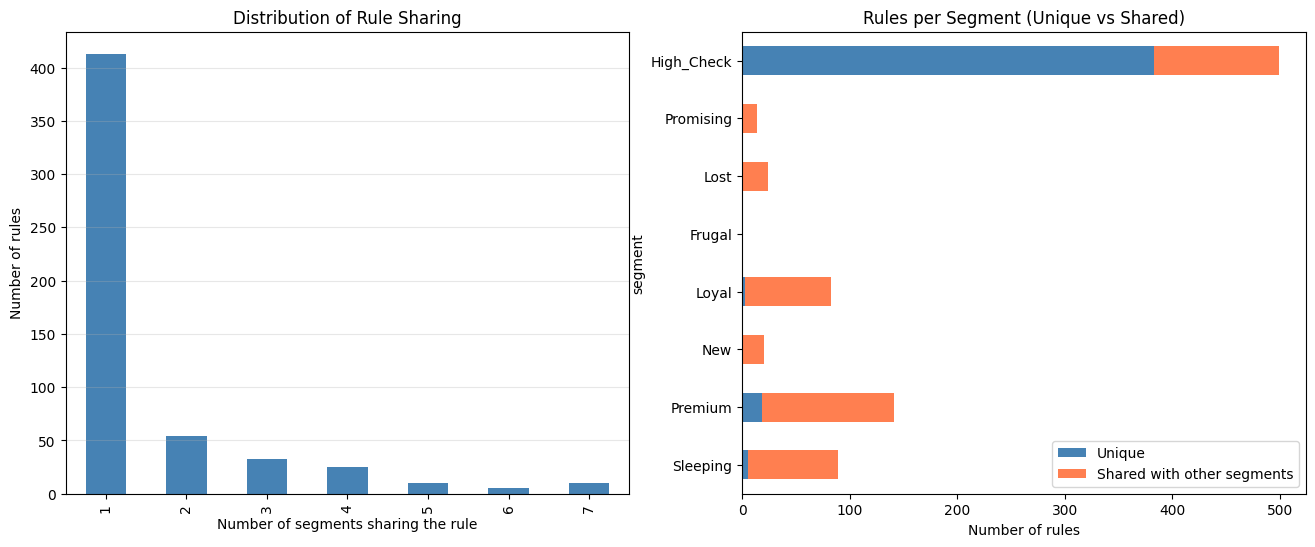

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# COMPARE RULES BETWEEN SEGMENTS

print("Loading rules by segment...")
segment_rules = pd.read_csv('../data/processed/rules_by_segment.csv')

print(f"Total rules: {len(segment_rules):,}")
print(f"Segments: {segment_rules['segment'].nunique()}")

# 1. CREATE RULE IDENTIFIER

# Create unique rule identifier (antecedent -> consequent)
segment_rules['rule_id'] = segment_rules['antecedent'] + ' -> ' + segment_rules['consequent']

print(f"\nUnique rules (across all segments): {segment_rules['rule_id'].nunique()}")

# 2. RULES SHARED BETWEEN SEGMENTS

# Count how many segments share each rule
rule_counts = segment_rules.groupby('rule_id')['segment'].apply(lambda x: list(x)).reset_index()
rule_counts['n_segments'] = rule_counts['segment'].apply(len)
rule_counts['segments_list'] = rule_counts['segment'].apply(lambda x: ', '.join(sorted(x)))

# Distribution
print("\nRule sharing distribution:")
sharing_dist = rule_counts['n_segments'].value_counts().sort_index()
for n_seg, count in sharing_dist.items():
    pct = count / len(rule_counts) * 100
    print(f"  Rules in {n_seg} segment(s): {count:4d} ({pct:5.1f}%)")

# Unique vs shared
unique_rules = rule_counts[rule_counts['n_segments'] == 1]
shared_rules = rule_counts[rule_counts['n_segments'] > 1]

print(f"\nSummary:")
print(f"  Unique rules (1 segment only): {len(unique_rules)} ({len(unique_rules)/len(rule_counts)*100:.1f}%)")
print(f"  Shared rules (2+ segments): {len(shared_rules)} ({len(shared_rules)/len(rule_counts)*100:.1f}%)")


# 3. TOP SHARED RULES

print("\n" + "="*70)
print("TOP 20 MOST SHARED RULES")
print("="*70)

most_shared = rule_counts.sort_values('n_segments', ascending=False).head(20)

for idx, row in most_shared.iterrows():
    print(f"\nRule: {row['rule_id']}")
    print(f"  Shared by {row['n_segments']} segments: {row['segments_list']}")


# 4. UNIQUE RULES PER SEGMENT


for seg in seg_list:
    # Rules unique to this segment
    seg_rules = set(segment_rules[segment_rules['segment'] == seg]['rule_id'])

    # Rules from other segments
    other_rules = set(segment_rules[segment_rules['segment'] != seg]['rule_id'])

    # Unique rules
    unique_to_seg = seg_rules - other_rules

    n_total = len(seg_rules)
    n_unique = len(unique_to_seg)
    pct_unique = (n_unique / n_total * 100) if n_total > 0 else 0

    print(f"\n{seg}:")
    print(f"  Total rules: {n_total}")
    print(f"  Unique rules: {n_unique} ({pct_unique:.1f}%)")


# 5. VISUALIZATION

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Rule sharing distribution
ax1 = axes[0]
sharing_dist.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_xlabel('Number of segments sharing the rule')
ax1.set_ylabel('Number of rules')
ax1.set_title('Distribution of Rule Sharing')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Rules per segment (unique vs shared)
ax2 = axes[1]
seg_stats = []
for seg in seg_list:
    seg_rules = set(segment_rules[segment_rules['segment'] == seg]['rule_id'])
    other_rules = set(segment_rules[segment_rules['segment'] != seg]['rule_id'])
    unique = len(seg_rules - other_rules)
    shared = len(seg_rules & other_rules)
    seg_stats.append({'segment': seg, 'unique': unique, 'shared': shared})

seg_stats_df = pd.DataFrame(seg_stats).set_index('segment')
seg_stats_df.plot(kind='barh', stacked=True, ax=ax2, color=['steelblue', 'coral'])
ax2.set_xlabel('Number of rules')
ax2.set_title('Rules per Segment (Unique vs Shared)')
ax2.legend(['Unique', 'Shared with other segments'])


In [12]:
# Comparison of approaches


comparison = pd.DataFrame([
    {
        'Approach': 'By Department',
        'Rules': len(dept_rules),
        'Precision@10': f"{metrics_dept['precision@K']:.2%}",
        'Recall@10': f"{metrics_dept['recall@K']:.2%}",
        'Coverage': f"{metrics_dept['coverage']:.2%}",
        'Avg Hits': f"{metrics_dept['avg_hits']:.2f}"
    },
    {
        'Approach': 'Cross-Department',
        'Rules': len(general_rules) if general_rules is not None else 0,
        'Precision@10': f"{metrics_general['precision@K']:.2%}" if metrics_general else 'N/A',
        'Recall@10': f"{metrics_general['recall@K']:.2%}" if metrics_general else 'N/A',
        'Coverage': f"{metrics_general['coverage']:.2%}" if metrics_general else 'N/A',
        'Avg Hits': f"{metrics_general['avg_hits']:.2f}" if metrics_general else 'N/A'
    },
    {
        'Approach': 'By Segment',
        'Rules': len(segment_rules) if all_seg_rules else 0,
        'Precision@10': f"{metrics_seg['precision@K']:.2%}" if metrics_seg else 'N/A',
        'Recall@10': f"{metrics_seg['recall@K']:.2%}" if metrics_seg else 'N/A',
        'Coverage': f"{metrics_seg['coverage']:.2%}" if metrics_seg else 'N/A',
        'Avg Hits': f"{metrics_seg['avg_hits']:.2f}" if metrics_seg else 'N/A'
    }
])

print(comparison.to_string(index=False))

        Approach  Rules Precision@10 Recall@10 Coverage Avg Hits
   By Department    459        8.10%     3.94%   26.66%     0.23
Cross-Department     82        9.03%     3.52%   49.46%     0.23
      By Segment    870        8.09%     3.57%   53.92%     0.23


In [18]:
## V. Cross-department association rules (inter-department only)

# Build product -> department mapping (small, fits in memory)
product_dept_map = products.merge(
    departments[['department_id', 'department']], on='department_id'
)[['product_name', 'department']].set_index('product_name')['department'].to_dict()

# Generate rules on top N products across ALL departments
# More products than section II to maximize cross-dept coverage
transactions_cross = prepare_transactions_from_csv(
    TRAIN_ENRICHED_PATH,
    top_n_products=500
)

print(f"  Total transactions: {len(transactions_cross):,}")

cross_rules = generate_association_rules(
    transactions_cross,
    min_support=0.003,
    min_confidence=0.10,
    min_lift=1.3,
    max_transactions=200_000
)

if cross_rules is not None:

    # Add department for each side of the rule
    # For multi-product antecedents/consequents, take the most common dept
    def get_dept(product_str):
        products_list = product_str.split(', ')
        depts = [product_dept_map.get(p) for p in products_list if product_dept_map.get(p)]
        if not depts:
            return None
        return max(set(depts), key=depts.count)  # most frequent dept

    cross_rules['antecedent_dept'] = cross_rules['antecedent'].apply(get_dept)
    cross_rules['consequent_dept']  = cross_rules['consequent'].apply(get_dept)

    # Keep only inter-department rules
    inter_dept_rules = cross_rules[
        cross_rules['antecedent_dept'] != cross_rules['consequent_dept']
    ].copy()

    print(f"\nTotal cross-dept rules (all):  {len(cross_rules):,}")
    print(f"Inter-department rules only:   {len(inter_dept_rules):,}")

    inter_dept_rules.to_csv('../data/processed/rules_cross_department.csv', index=False)

    # Show top rules per department pair
    print("\nTop rules by department pair:")
    top_pairs = (
        inter_dept_rules
        .groupby(['antecedent_dept', 'consequent_dept'])
        .apply(lambda x: x.nlargest(1, 'lift'))
        .reset_index(drop=True)
        .sort_values('lift', ascending=False)
        .head(20)
    )
    for _, row in top_pairs.iterrows():
        print(f"  [{row['antecedent_dept']} → {row['consequent_dept']}]  "
              f"{row['antecedent']} → {row['consequent']}  "
              f"(lift={row['lift']:.2f}, conf={row['confidence']:.2%})")

    # Evaluate
    metrics_cross_dept = evaluate_rules_from_csv(
        rules=inter_dept_rules,
        filepath=TEST_ENRICHED_PATH,
        k=10
    )
    print_evaluation_results(metrics_cross_dept)

else:
    print("No cross-department rules generated")
    inter_dept_rules = None
    metrics_cross_dept = None

    Computing top 500 products (pass 1/2)...
    Building transactions (pass 2/2)...
  Total transactions: 2,024,863

Total cross-dept rules (all):  304
Inter-department rules only:   33

Top rules by department pair:
  [frozen → produce]  Blueberries → Strawberries  (lift=3.10, conf=15.62%)
  [dairy eggs → produce]  Organic Whole String Cheese → Organic Strawberries  (lift=2.55, conf=23.53%)
  [meat seafood → produce]  Boneless Skinless Chicken Breasts → Organic Avocado  (lift=2.31, conf=15.56%)
  [deli → produce]  Original Hummus → Organic Hass Avocado  (lift=2.04, conf=14.29%)
  [canned goods → produce]  No Salt Added Black Beans → Banana  (lift=1.76, conf=29.67%)
  [bakery → produce]  100% Whole Wheat Bread → Banana  (lift=1.53, conf=25.75%)
    Building test baskets from CSV...


/tmp/ipykernel_23230/1049638673.py:54: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(1, 'lift'))


  Precision@10: 8.00%
  Recall@10: 3.03%
  Coverage: 15.38%
  Average hits: 0.20
  Baskets evaluated: 10,000
  Baskets with recommendations: 1,538


In [ ]:
## V. Cross-department association rules (explicit pairs)

# Define department pairs to study
DEPT_PAIRS = [
    ('snacks', 'beverages'),
    ('produce', 'meat seafood'),
    ('snacks', 'alcohol'),
    ('personal care', 'babies'),
    ('dairy eggs', 'bakery'),
    ('frozen', 'beverages'),
    ('produce', 'dairy eggs'),
    ('breakfast', 'dairy eggs'),
]

# Config per pair
PAIR_CONFIG = {
    'n_products': 100,      # top N per department
    'max_trans': 150_000,
    'supp': 0.003,
    'conf': 0.10,
    'lift': 1.3
}

all_pair_rules = []

for i, (dept_a, dept_b) in enumerate(DEPT_PAIRS, 1):
    print(f"  [{i}/{len(DEPT_PAIRS)}] {dept_a} × {dept_b}...", end=' ')

    # Get top N products for each department separately
    top_a = get_top_products_from_csv(
        TRAIN_ENRICHED_PATH,
        top_n=PAIR_CONFIG['n_products'],
        filter_column='department',
        filter_values=dept_a
    )
    top_b = get_top_products_from_csv(
        TRAIN_ENRICHED_PATH,
        top_n=PAIR_CONFIG['n_products'],
        filter_column='department',
        filter_values=dept_b
    )
    allowed_products = top_a | top_b  # union of both sets

    # Build transactions containing products from BOTH departments
    # (only keep baskets that have at least 1 product from each dept)
    transactions_dict = {}
    dept_presence = {}  # order_id -> set of depts present

    for chunk in csv_chunk_generator(TRAIN_ENRICHED_PATH):
        chunk_filtered = chunk[chunk['product_name'].isin(allowed_products)]
        for order_id, group in chunk_filtered.groupby('order_id'):
            if order_id not in transactions_dict:
                transactions_dict[order_id] = []
                dept_presence[order_id] = set()
            transactions_dict[order_id].extend(group['product_name'].tolist())
            dept_presence[order_id].update(group['department'].tolist())

    # Keep only baskets with products from BOTH departments
    transactions = [
        prods for oid, prods in transactions_dict.items()
        if dept_a in dept_presence[oid] and dept_b in dept_presence[oid]
    ]

    print(f"{len(transactions):,} mixed baskets...", end=' ')

    if len(transactions) < 100:
        print("Not enough baskets, skipping")
        continue

    # Generate rules
    rules = generate_association_rules(
        transactions,
        min_support=PAIR_CONFIG['supp'],
        min_confidence=PAIR_CONFIG['conf'],
        min_lift=PAIR_CONFIG['lift'],
        max_transactions=PAIR_CONFIG['max_trans']
    )

    if rules is not None:
        # Keep only inter-department rules
        rules['antecedent_dept'] = rules['antecedent'].apply(
            lambda x: product_dept_map.get(x.split(', ')[0])
        )
        rules['consequent_dept'] = rules['consequent'].apply(
            lambda x: product_dept_map.get(x.split(', ')[0])
        )
        inter_rules = rules[
            rules['antecedent_dept'] != rules['consequent_dept']
        ].copy()
        inter_rules['pair'] = f"{dept_a} × {dept_b}"

        all_pair_rules.append(inter_rules)
        print(f"{len(inter_rules)} inter-dept rules")
    else:
        print("No rules")

# Consolidate
if all_pair_rules:
    pair_rules = pd.concat(all_pair_rules, ignore_index=True)
    pair_rules.to_csv('../data/processed/rules_cross_department.csv', index=False)
    print(f"\nTotal cross-department rules: {len(pair_rules):,}")

    # Top rules per pair
    print("\nTop 3 rules per pair (by lift):")
    for pair, group in pair_rules.groupby('pair'):
        print(f"\n  {pair}:")
        for _, row in group.nlargest(3, 'lift').iterrows():
            print(f"    {row['antecedent']} → {row['consequent']}  "
                  f"(lift={row['lift']:.2f}, conf={row['confidence']:.2%})")
else:
    print("No cross-department rules generated")
    pair_rules = None

  [1/8] snacks × beverages...     Computing top 100 products (pass 1/2)...
    Computing top 100 products (pass 1/2)...
166,208 mixed baskets... 25 inter-dept rules
  [2/8] produce × meat seafood...     Computing top 100 products (pass 1/2)...
    Computing top 100 products (pass 1/2)...
287,018 mixed baskets... 124 inter-dept rules
  [3/8] snacks × alcohol...     Computing top 100 products (pass 1/2)...
    Computing top 100 products (pass 1/2)...
7,469 mixed baskets... 39 inter-dept rules
  [4/8] personal care × babies...     Computing top 100 products (pass 1/2)...
    Computing top 100 products (pass 1/2)...
3,969 mixed baskets... 154 inter-dept rules
  [5/8] dairy eggs × bakery...     Computing top 100 products (pass 1/2)...
    Computing top 100 products (pass 1/2)...
237,233 mixed baskets... 11 inter-dept rules
  [6/8] frozen × beverages...     Computing top 100 products (pass 1/2)...
    Computing top 100 products (pass 1/2)...
151,409 mixed baskets... 2 inter-dept rules
  [7/8